In [ ]:

import pandas as pd
import numpy as np
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import warnings
warnings.filterwarnings('ignore')

# Load datasets
print("Loading datasets...")
allosteric_df = pd.read_csv('definitive_top_100_candidates_v3.csv')
partial_graft_df = pd.read_csv('partial_graft_designs.csv')
diversified_cdr_df = pd.read_csv('diversified_cdr_designs.csv')

print(f"Allosteric designs: {len(allosteric_df)} rows")
print(f"Partial graft designs: {len(partial_graft_df)} rows")
print(f"Diversified CDR designs: {len(diversified_cdr_df)} rows")

# Examine structure of each dataframe
print("\n=== Allosteric DF columns ===")
print(allosteric_df.columns.tolist())
print(allosteric_df.head(3))

print("\n=== Partial Graft DF columns ===")
print(partial_graft_df.columns.tolist())
print(partial_graft_df.head(3))

print("\n=== Diversified CDR DF columns ===")
print(diversified_cdr_df.columns.tolist())
print(diversified_cdr_df.head(3))


Loading datasets...
Allosteric designs: 100 rows
Partial graft designs: 964 rows
Diversified CDR designs: 12243 rows

=== Allosteric DF columns ===
['Final_Rank', 'Sequence', 'Design_Strategy', 'Motif', 'Refined_MJ_Score']
   Final_Rank                                           Sequence  \
0           1  MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTLY...   
1           2  MQYKLILNGKTLKGETTTEAVDAATAEKVLYDFGISFMDGEWTYDD...   
2           3  RLDAPSQIEVKDVTDTTALITWFKPLAEIDGIELTYGIKDVPGDRT...   

  Design_Strategy      Motif  Refined_MJ_Score  
0      Hybrid_3.0  LYDFGISFM           -419.68  
1      Hybrid_3.0  LYDFGISFM           -419.68  
2      Hybrid_3.0  LYDFGISFM           -419.68  

=== Partial Graft DF columns ===
['Scaffold', 'Loop_Position', 'Loop_Range', 'Parent_Antibody', 'Parent_CDR', 'Parent_Sequence', 'Subsequence', 'Subseq_Length', 'Design_Sequence', 'Epitope_Type', 'Sequence_Score', 'Normalized_Sequence_Score']
  Scaffold  Loop_Position Loop_Range Parent_Antibody Parent_CDR 

In [ ]:

# Step 1: Select top 50 allosteric candidates
# Already sorted by Refined_MJ_Score (higher is better for binding - more negative is better)
allosteric_top50 = allosteric_df.head(50).copy()
print(f"Selected top 50 allosteric designs")
print(f"Score range: {allosteric_top50['Refined_MJ_Score'].min():.2f} to {allosteric_top50['Refined_MJ_Score'].max():.2f}")
print(f"\nTop 5 allosteric:")
print(allosteric_top50[['Final_Rank', 'Motif', 'Refined_MJ_Score']].head())


Selected top 50 allosteric designs
Score range: -419.68 to -415.26

Top 5 allosteric:
   Final_Rank      Motif  Refined_MJ_Score
0           1  LYDFGISFM           -419.68
1           2  LYDFGISFM           -419.68
2           3  LYDFGISFM           -419.68
3           4  LYDFGISFM           -419.68
4           5  LYDFGISFM           -419.68


In [ ]:

# Step 2: Process competitive candidates
# Filter for competitive designs from both datasets

# Filter partial_graft_df for competitive
partial_comp = partial_graft_df[partial_graft_df['Epitope_Type'] == 'competitive'].copy()
print(f"Competitive designs from partial_graft: {len(partial_comp)}")

# Filter diversified_cdr_df for competitive
diversified_comp = diversified_cdr_df[diversified_cdr_df['source'] == 'competitive'].copy()
print(f"Competitive designs from diversified_cdr: {len(diversified_comp)}")

# Check if rule_based_competitive_designs.csv exists
import os
if os.path.exists('rule_based_competitive_designs.csv'):
    rule_based_comp = pd.read_csv('rule_based_competitive_designs.csv')
    print(f"Competitive designs from rule_based: {len(rule_based_comp)}")
else:
    print("rule_based_competitive_designs.csv not found - proceeding with available datasets")
    rule_based_comp = None


Competitive designs from partial_graft: 405
Competitive designs from diversified_cdr: 4683
rule_based_competitive_designs.csv not found - proceeding with available datasets


In [ ]:

# Examine the scoring columns in competitive datasets
print("=== Partial graft competitive - score columns ===")
print(partial_comp[['Subsequence', 'Subseq_Length', 'Sequence_Score', 'Normalized_Sequence_Score']].head())
print(f"\nSubsequence length distribution:")
print(partial_comp['Subseq_Length'].value_counts().sort_index())

print("\n=== Diversified CDR competitive - score columns ===")
print(diversified_comp[['variant_cdr_sequence', 'cdr_length', 'raw_interaction_score', 'normalized_interaction_score']].head())
print(f"\nCDR length distribution:")
print(diversified_comp['cdr_length'].value_counts().sort_index())


=== Partial graft competitive - score columns ===
  Subsequence  Subseq_Length  Sequence_Score  Normalized_Sequence_Score
0    ARDYQYYY              8            16.5                     2.0625
1    ARDYQYYY              8            16.5                     2.0625
2    ARDYQYYY              8            16.5                     2.0625
3    ARDYQYYY              8            16.5                     2.0625
4    ARDYQYYY              8            16.5                     2.0625

Subsequence length distribution:
Subseq_Length
8    234
9    171
Name: count, dtype: int64

=== Diversified CDR competitive - score columns ===
  variant_cdr_sequence  cdr_length  raw_interaction_score  \
0           GGAISDTYRW          10                   -2.4   
1           GGAISDTYRW          10                   -2.4   
2           GGAISDTYRW          10                   -2.4   
3           GGNISDTYRW          10                   -3.1   
4           GGNISDTYRW          10                   -3.1   

   nor

In [ ]:

# Based on the dataset description, partial_graft_df uses sequence-based scores that are NOT comparable
# to physics-based MJ scores. We need to re-score these designs with the MJ scoring function.
# However, diversified_cdr_df already has raw_interaction_score (MJ-based).

# The description states that for partial grafts, we need to calculate MJ scores for the motifs.
# Since we don't have the competitive epitope structure loaded, we need to check if there's 
# a way to get these scores or if they need to be recalculated.

# For now, let's focus on the diversified_cdr_df which already has physics-based scores.
# We need to extract the motif (variant_cdr_sequence) and raw_interaction_score.

# Prepare diversified competitive data
div_comp_prep = diversified_comp[['design_id', 'scaffold', 'variant_cdr_sequence', 
                                   'cdr_length', 'raw_interaction_score', 
                                   'normalized_interaction_score']].copy()

# Rename columns for consistency
div_comp_prep = div_comp_prep.rename(columns={
    'variant_cdr_sequence': 'Motif',
    'cdr_length': 'Motif_Length',
    'raw_interaction_score': 'Raw_MJ_Score'
})

print(f"Diversified competitive candidates prepared: {len(div_comp_prep)}")
print(f"\nMotif length distribution:")
print(div_comp_prep['Motif_Length'].value_counts().sort_index())
print(f"\nRaw MJ score range: {div_comp_prep['Raw_MJ_Score'].min():.2f} to {div_comp_prep['Raw_MJ_Score'].max():.2f}")


Diversified competitive candidates prepared: 4683

Motif length distribution:
Motif_Length
10    1293
12    2427
17     963
Name: count, dtype: int64

Raw MJ score range: -6.80 to -1.20


In [ ]:

# The partial_graft designs need to be re-scored with MJ scoring.
# We'll need to implement the MJ scoring function to score the competitive epitope.
# Load the competitive epitope sequence

# The competitive epitope is defined as a 20-residue core
competitive_epitope = "SCSRGVSKQRIIGVGEVLDR"
print(f"Competitive epitope: {competitive_epitope}")
print(f"Length: {len(competitive_epitope)}")

# Implement Miyazawa-Jernigan scoring function
# MJ contact energy matrix (20x20 for amino acids)
mj_matrix = {
    ('A', 'A'): -0.30, ('A', 'C'): -0.11, ('A', 'D'): -0.18, ('A', 'E'): -0.19, ('A', 'F'): -0.37,
    ('A', 'G'): -0.13, ('A', 'H'): -0.24, ('A', 'I'): -0.27, ('A', 'K'): -0.22, ('A', 'L'): -0.45,
    ('A', 'M'): -0.27, ('A', 'N'): -0.15, ('A', 'P'): -0.18, ('A', 'Q'): -0.15, ('A', 'R'): -0.29,
    ('A', 'S'): -0.10, ('A', 'T'): -0.17, ('A', 'V'): -0.38, ('A', 'W'): -0.21, ('A', 'Y'): -0.15,
    ('C', 'C'): -0.66, ('C', 'D'): -0.36, ('C', 'E'): -0.15, ('C', 'F'): -0.52, ('C', 'G'): -0.20,
    ('C', 'H'): -0.37, ('C', 'I'): -0.65, ('C', 'K'): -0.12, ('C', 'L'): -0.49, ('C', 'M'): -0.48,
    ('C', 'N'): -0.26, ('C', 'P'): -0.53, ('C', 'Q'): -0.26, ('C', 'R'): -0.21, ('C', 'S'): -0.26,
    ('C', 'T'): -0.18, ('C', 'V'): -0.48, ('C', 'W'): -0.49, ('C', 'Y'): -0.53,
    ('D', 'D'): -0.11, ('D', 'E'):  0.02, ('D', 'F'): -0.26, ('D', 'G'): -0.14, ('D', 'H'): -0.24,
    ('D', 'I'): -0.19, ('D', 'K'):  0.03, ('D', 'L'): -0.40, ('D', 'M'): -0.34, ('D', 'N'): -0.05,
    ('D', 'P'): -0.31, ('D', 'Q'): -0.10, ('D', 'R'): -0.07, ('D', 'S'): -0.03, ('D', 'T'): -0.14,
    ('D', 'V'): -0.26, ('D', 'W'): -0.38, ('D', 'Y'): -0.25,
    ('E', 'E'): -0.11, ('E', 'F'): -0.43, ('E', 'G'): -0.21, ('E', 'H'): -0.27, ('E', 'I'): -0.39,
    ('E', 'K'):  0.02, ('E', 'L'): -0.40, ('E', 'M'): -0.30, ('E', 'N'): -0.06, ('E', 'P'): -0.31,
    ('E', 'Q'): -0.20, ('E', 'R'): -0.16, ('E', 'S'): -0.11, ('E', 'T'): -0.19, ('E', 'V'): -0.31,
    ('E', 'W'): -0.49, ('E', 'Y'): -0.31,
    ('F', 'F'): -0.61, ('F', 'G'): -0.41, ('F', 'H'): -0.42, ('F', 'I'): -0.68, ('F', 'K'): -0.39,
    ('F', 'L'): -0.59, ('F', 'M'): -0.60, ('F', 'N'): -0.35, ('F', 'P'): -0.46, ('F', 'Q'): -0.41,
    ('F', 'R'): -0.41, ('F', 'S'): -0.32, ('F', 'T'): -0.35, ('F', 'V'): -0.62, ('F', 'W'): -0.58,
    ('F', 'Y'): -0.39,
    ('G', 'G'): -0.18, ('G', 'H'): -0.32, ('G', 'I'): -0.36, ('G', 'K'): -0.25, ('G', 'L'): -0.42,
    ('G', 'M'): -0.32, ('G', 'N'): -0.21, ('G', 'P'): -0.25, ('G', 'Q'): -0.25, ('G', 'R'): -0.29,
    ('G', 'S'): -0.10, ('G', 'T'): -0.17, ('G', 'V'): -0.30, ('G', 'W'): -0.41, ('G', 'Y'): -0.35,
    ('H', 'H'): -0.13, ('H', 'I'): -0.39, ('H', 'K'): -0.22, ('H', 'L'): -0.44, ('H', 'M'): -0.35,
    ('H', 'N'): -0.23, ('H', 'P'): -0.32, ('H', 'Q'): -0.24, ('H', 'R'): -0.24, ('H', 'S'): -0.17,
    ('H', 'T'): -0.25, ('H', 'V'): -0.35, ('H', 'W'): -0.38, ('H', 'Y'): -0.19,
    ('I', 'I'): -0.60, ('I', 'K'): -0.29, ('I', 'L'): -0.55, ('I', 'M'): -0.52, ('I', 'N'): -0.27,
    ('I', 'P'): -0.38, ('I', 'Q'): -0.35, ('I', 'R'): -0.34, ('I', 'S'): -0.21, ('I', 'T'): -0.33,
    ('I', 'V'): -0.62, ('I', 'W'): -0.56, ('I', 'Y'): -0.43,
    ('K', 'K'):  0.11, ('K', 'L'): -0.41, ('K', 'M'): -0.32, ('K', 'N'): -0.09, ('K', 'P'): -0.28,
    ('K', 'Q'): -0.11, ('K', 'R'):  0.08, ('K', 'S'): -0.07, ('K', 'T'): -0.16, ('K', 'V'): -0.32,
    ('K', 'W'): -0.45, ('K', 'Y'): -0.34,
    ('L', 'L'): -0.56, ('L', 'M'): -0.52, ('L', 'N'): -0.35, ('L', 'P'): -0.45, ('L', 'Q'): -0.38,
    ('L', 'R'): -0.39, ('L', 'S'): -0.29, ('L', 'T'): -0.35, ('L', 'V'): -0.56, ('L', 'W'): -0.54,
    ('L', 'Y'): -0.43,
    ('M', 'M'): -0.45, ('M', 'N'): -0.30, ('M', 'P'): -0.39, ('M', 'Q'): -0.30, ('M', 'R'): -0.34,
    ('M', 'S'): -0.22, ('M', 'T'): -0.29, ('M', 'V'): -0.48, ('M', 'W'): -0.51, ('M', 'Y'): -0.41,
    ('N', 'N'): -0.01, ('N', 'P'): -0.28, ('N', 'Q'): -0.11, ('N', 'R'): -0.15, ('N', 'S'): -0.06,
    ('N', 'T'): -0.13, ('N', 'V'): -0.28, ('N', 'W'): -0.40, ('N', 'Y'): -0.24,
    ('P', 'P'): -0.22, ('P', 'Q'): -0.28, ('P', 'R'): -0.29, ('P', 'S'): -0.20, ('P', 'T'): -0.24,
    ('P', 'V'): -0.38, ('P', 'W'): -0.48, ('P', 'Y'): -0.38,
    ('Q', 'Q'): -0.18, ('Q', 'R'): -0.20, ('Q', 'S'): -0.10, ('Q', 'T'): -0.18, ('Q', 'V'): -0.34,
    ('Q', 'W'): -0.45, ('Q', 'Y'): -0.31,
    ('R', 'R'):  0.04, ('R', 'S'): -0.10, ('R', 'T'): -0.18, ('R', 'V'): -0.33, ('R', 'W'): -0.45,
    ('R', 'Y'): -0.34,
    ('S', 'S'):  0.01, ('S', 'T'): -0.08, ('S', 'V'): -0.20, ('S', 'W'): -0.34, ('S', 'Y'): -0.23,
    ('T', 'T'): -0.12, ('T', 'V'): -0.30, ('T', 'W'): -0.37, ('T', 'Y'): -0.28,
    ('V', 'V'): -0.54, ('V', 'W'): -0.53, ('V', 'Y'): -0.41,
    ('W', 'W'): -0.55, ('W', 'Y'): -0.35,
    ('Y', 'Y'): -0.23
}

# Make matrix symmetric
mj_symmetric = {}
for (aa1, aa2), score in mj_matrix.items():
    mj_symmetric[(aa1, aa2)] = score
    mj_symmetric[(aa2, aa1)] = score

print(f"\nMJ matrix loaded with {len(mj_symmetric)} entries")


Competitive epitope: SCSRGVSKQRIIGVGEVLDR
Length: 20

MJ matrix loaded with 400 entries


In [ ]:

# Implement MJ scoring function for motif-epitope interactions
def calculate_mj_score(motif_seq, epitope_seq, mj_matrix):
    """
    Calculate Miyazawa-Jernigan interaction score between motif and epitope.
    Score is sum of all pairwise interactions between residues.
    More negative = better binding.
    """
    score = 0.0
    for aa1 in motif_seq:
        for aa2 in epitope_seq:
            if (aa1, aa2) in mj_matrix:
                score += mj_matrix[(aa1, aa2)]
            else:
                # Handle non-standard amino acids by skipping
                pass
    return score

# Test the function
test_motif = "LYDFGISFM"  # Top allosteric motif
test_score = calculate_mj_score(test_motif, competitive_epitope, mj_symmetric)
print(f"Test MJ score for motif {test_motif}: {test_score:.2f}")

# Calculate MJ scores for all partial graft competitive designs
print("\nCalculating MJ scores for partial graft competitive designs...")
partial_comp['Raw_MJ_Score'] = partial_comp['Subsequence'].apply(
    lambda x: calculate_mj_score(x, competitive_epitope, mj_symmetric)
)

print(f"Partial graft MJ scores calculated")
print(f"Score range: {partial_comp['Raw_MJ_Score'].min():.2f} to {partial_comp['Raw_MJ_Score'].max():.2f}")
print(f"\nTop 5 partial graft by MJ score:")
print(partial_comp.nlargest(5, 'Raw_MJ_Score')[['Subsequence', 'Subseq_Length', 'Raw_MJ_Score']])


Test MJ score for motif LYDFGISFM: -59.86

Calculating MJ scores for partial graft competitive designs...
Partial graft MJ scores calculated
Score range: -55.92 to -35.45

Top 5 partial graft by MJ score:
    Subsequence  Subseq_Length  Raw_MJ_Score
482    GSISDTYR              8        -35.45
483    GSISDTYR              8        -35.45
484    GSISDTYR              8        -35.45
485    GSISDTYR              8        -35.45
486    GSISDTYR              8        -35.45


In [ ]:

# Now we need to prepare and consolidate all competitive designs
# Prepare partial graft data
partial_comp_prep = partial_comp[['Subsequence', 'Subseq_Length', 'Raw_MJ_Score', 
                                   'Design_Sequence', 'Scaffold']].copy()
partial_comp_prep = partial_comp_prep.rename(columns={
    'Subsequence': 'Motif',
    'Subseq_Length': 'Motif_Length',
    'Design_Sequence': 'Sequence'
})
partial_comp_prep['Source'] = 'Partial_Graft'

print(f"Partial graft competitive: {len(partial_comp_prep)} designs")
print(f"Motif lengths: {partial_comp_prep['Motif_Length'].unique()}")

# For diversified_cdr, we need to get the full design sequences
# Check if we have the full sequences
print("\n=== Diversified CDR columns ===")
print(diversified_comp.columns.tolist())

# We need to construct or retrieve the full sequences for diversified designs
# Let's check if there are sequence columns we can use
print("\nSample diversified_comp data:")
print(diversified_comp.head(2))


Partial graft competitive: 405 designs
Motif lengths: [8 9]

=== Diversified CDR columns ===
['design_id', 'scaffold', 'source', 'parent_antibody', 'parent_cdr', 'original_cdr_sequence', 'variant_cdr_sequence', 'mutations', 'num_mutations', 'cdr_length', 'raw_interaction_score', 'normalized_interaction_score', 'num_epitope_interactions']

Sample diversified_comp data:
      design_id scaffold       source parent_antibody parent_cdr  \
0  design_00000     1FNA  competitive             1E5         H1   
1  design_00001     1TEN  competitive             1E5         H1   

  original_cdr_sequence variant_cdr_sequence mutations  num_mutations  \
0            GGSISDTYRW           GGAISDTYRW       S3A              1   
1            GGSISDTYRW           GGAISDTYRW       S3A              1   

   cdr_length  raw_interaction_score  normalized_interaction_score  \
0          10                   -2.4                         -0.24   
1          10                   -2.4                         -0.

In [ ]:

# The diversified_cdr_df doesn't have full design sequences stored
# We need to reconstruct them based on scaffold + grafted CDR
# However, for the purpose of ranking and selection, we can work with the motif sequences
# and later reconstruct full sequences when needed for the final output

# For now, let's create a placeholder approach:
# We'll track the design_id and scaffold, and can reconstruct sequences later
# But we notice that these designs don't have full sequences readily available

# Let's check if we can find the scaffold sequences or need to build them
# First, let's consolidate what we have and rank by scores

# Combine all competitive candidates with their motifs and scores
# For partial graft: we have full sequences
# For diversified CDR: we need to note that full sequences are not directly available

# Let's focus on creating a unified ranking dataset first
print("Creating unified competitive candidate dataset...")

# Partial graft data is ready
print(f"\nPartial graft competitive designs: {len(partial_comp_prep)}")
print(partial_comp_prep[['Motif', 'Motif_Length', 'Raw_MJ_Score', 'Source']].head())

# For diversified CDR, we'll prepare what we have
div_comp_prep2 = diversified_comp[['design_id', 'scaffold', 'variant_cdr_sequence', 
                                    'cdr_length', 'raw_interaction_score']].copy()
div_comp_prep2 = div_comp_prep2.rename(columns={
    'variant_cdr_sequence': 'Motif',
    'cdr_length': 'Motif_Length',
    'raw_interaction_score': 'Raw_MJ_Score'
})
div_comp_prep2['Source'] = 'Diversified_CDR'
div_comp_prep2['Sequence'] = None  # Placeholder for full sequence

print(f"\nDiversified CDR competitive designs: {len(div_comp_prep2)}")
print(div_comp_prep2[['Motif', 'Motif_Length', 'Raw_MJ_Score', 'Source']].head())


Creating unified competitive candidate dataset...

Partial graft competitive designs: 405
      Motif  Motif_Length  Raw_MJ_Score         Source
0  ARDYQYYY             8        -43.69  Partial_Graft
1  ARDYQYYY             8        -43.69  Partial_Graft
2  ARDYQYYY             8        -43.69  Partial_Graft
3  ARDYQYYY             8        -43.69  Partial_Graft
4  ARDYQYYY             8        -43.69  Partial_Graft

Diversified CDR competitive designs: 4683
        Motif  Motif_Length  Raw_MJ_Score           Source
0  GGAISDTYRW            10          -2.4  Diversified_CDR
1  GGAISDTYRW            10          -2.4  Diversified_CDR
2  GGAISDTYRW            10          -2.4  Diversified_CDR
3  GGNISDTYRW            10          -3.1  Diversified_CDR
4  GGNISDTYRW            10          -3.1  Diversified_CDR


In [ ]:

# Now I need to apply length-correction to competitive candidates
# According to the objective, we need to:
# 1. For variable-length motifs: calculate Residual Score using quadratic regression (a=1.59, b=-146.30, c=59.34)
# 2. For 9-mer motifs: use raw MJ score directly
# 3. Z-score normalize each group separately, then combine

# First, let's consolidate all competitive designs
all_competitive = pd.concat([
    partial_comp_prep[['Motif', 'Motif_Length', 'Raw_MJ_Score', 'Source', 'Sequence', 'Scaffold']],
    div_comp_prep2[['Motif', 'Motif_Length', 'Raw_MJ_Score', 'Source', 'Sequence', 'design_id', 'scaffold']]
], ignore_index=True)

print(f"Total competitive designs: {len(all_competitive)}")
print(f"\nMotif length distribution:")
print(all_competitive['Motif_Length'].value_counts().sort_index())

# Check for 9-mers
nine_mers = all_competitive[all_competitive['Motif_Length'] == 9]
variable_length = all_competitive[all_competitive['Motif_Length'] != 9]

print(f"\n9-mer designs: {len(nine_mers)}")
print(f"Variable-length designs: {len(variable_length)}")


Total competitive designs: 5088

Motif length distribution:
Motif_Length
8      234
9      171
10    1293
12    2427
17     963
Name: count, dtype: int64

9-mer designs: 171
Variable-length designs: 4917


In [ ]:

# Apply length correction as specified in the objective
# Quadratic regression coefficients from r43: a=1.59, b=-146.30, c=59.34
a, b, c = 1.59, -146.30, 59.34

# For variable-length motifs, calculate Residual Score
def calculate_residual_score(raw_score, length):
    """Calculate residual score: Actual - Predicted"""
    predicted = a * (length**2) + b * length + c
    return raw_score - predicted

# Process variable-length designs
variable_length = variable_length.copy()
variable_length['Predicted_Score'] = a * (variable_length['Motif_Length']**2) + b * variable_length['Motif_Length'] + c
variable_length['Residual_Score'] = variable_length['Raw_MJ_Score'] - variable_length['Predicted_Score']

# Z-score normalize residual scores for variable-length motifs
residual_mean = variable_length['Residual_Score'].mean()
residual_std = variable_length['Residual_Score'].std()
variable_length['Normalized_Score'] = (variable_length['Residual_Score'] - residual_mean) / residual_std

print(f"Variable-length motifs:")
print(f"  Residual score range: {variable_length['Residual_Score'].min():.2f} to {variable_length['Residual_Score'].max():.2f}")
print(f"  Mean residual: {residual_mean:.2f}, Std: {residual_std:.2f}")
print(f"  Normalized score range: {variable_length['Normalized_Score'].min():.2f} to {variable_length['Normalized_Score'].max():.2f}")

# For 9-mers, z-score normalize raw MJ scores
nine_mers = nine_mers.copy()
nine_mer_mean = nine_mers['Raw_MJ_Score'].mean()
nine_mer_std = nine_mers['Raw_MJ_Score'].std()
nine_mers['Normalized_Score'] = (nine_mers['Raw_MJ_Score'] - nine_mer_mean) / nine_mer_std

print(f"\n9-mer motifs:")
print(f"  Raw score range: {nine_mers['Raw_MJ_Score'].min():.2f} to {nine_mers['Raw_MJ_Score'].max():.2f}")
print(f"  Mean: {nine_mer_mean:.2f}, Std: {nine_mer_std:.2f}")
print(f"  Normalized score range: {nine_mers['Normalized_Score'].min():.2f} to {nine_mers['Normalized_Score'].max():.2f}")


Variable-length motifs:
  Residual score range: 957.98 to 1967.05
  Mean residual: 1479.54, Std: 272.07
  Normalized score range: -1.92 to 1.79

9-mer motifs:
  Raw score range: -55.92 to -39.59
  Mean: -46.07, Std: 4.11
  Normalized score range: -2.39 to 1.58


In [ ]:

# Combine normalized competitive designs and rank
# Combine variable-length and 9-mer designs
all_competitive_normalized = pd.concat([variable_length, nine_mers], ignore_index=True)

print(f"Total competitive designs after normalization: {len(all_competitive_normalized)}")
print(f"\nNormalized score distribution:")
print(all_competitive_normalized['Normalized_Score'].describe())

# Sort by Normalized_Score (higher is better - less negative)
all_competitive_normalized = all_competitive_normalized.sort_values('Normalized_Score', ascending=False)

print(f"\nTop 10 competitive designs by Normalized_Score:")
print(all_competitive_normalized[['Motif', 'Motif_Length', 'Raw_MJ_Score', 'Normalized_Score', 'Source']].head(10))

print(f"\nBottom 10 competitive designs by Normalized_Score:")
print(all_competitive_normalized[['Motif', 'Motif_Length', 'Raw_MJ_Score', 'Normalized_Score', 'Source']].tail(10))


Total competitive designs after normalization: 5088

Normalized score distribution:
count    5088.000000
mean        0.000000
std         0.999902
min        -2.393972
25%        -0.875454
50%        -0.059328
75%        -0.056020
max         1.791879
Name: Normalized_Score, dtype: float64

Top 10 competitive designs by Normalized_Score:
                  Motif  Motif_Length  Raw_MJ_Score  Normalized_Score  \
1642  ARDYQYYYAGSHPTPHN            17          -1.2          1.791879   
1643  ARDYQYYYAGSHPTPHN            17          -1.2          1.791879   
1101  ARDYEYYYAGSYPTPHN            17          -1.2          1.791879   
1641  ARDYQYYYAGSHPTPHN            17          -1.2          1.791879   
1102  ARDYEYYYAGSYPTPHN            17          -1.2          1.791879   
1103  ARDYEYYYAGSYPTPHN            17          -1.2          1.791879   
1157  ARDYEYYYSGSHPTPHN            17          -1.4          1.791144   
1155  ARDYEYYYSGSHPTPHN            17          -1.4          1.791144   
115

In [ ]:

# Select top 50 competitive candidates
competitive_top50 = all_competitive_normalized.head(50).copy()

print(f"Selected top 50 competitive designs")
print(f"Normalized score range: {competitive_top50['Normalized_Score'].min():.2f} to {competitive_top50['Normalized_Score'].max():.2f}")
print(f"\nSource distribution in top 50:")
print(competitive_top50['Source'].value_counts())
print(f"\nMotif length distribution in top 50:")
print(competitive_top50['Motif_Length'].value_counts().sort_index())

print(f"\nTop 5 competitive:")
print(competitive_top50[['Motif', 'Motif_Length', 'Raw_MJ_Score', 'Normalized_Score', 'Source']].head())


Selected top 50 competitive designs
Normalized score range: 1.79 to 1.79

Source distribution in top 50:
Source
Diversified_CDR    50
Name: count, dtype: int64

Motif length distribution in top 50:
Motif_Length
17    50
Name: count, dtype: int64

Top 5 competitive:
                  Motif  Motif_Length  Raw_MJ_Score  Normalized_Score  \
1642  ARDYQYYYAGSHPTPHN            17          -1.2          1.791879   
1643  ARDYQYYYAGSHPTPHN            17          -1.2          1.791879   
1101  ARDYEYYYAGSYPTPHN            17          -1.2          1.791879   
1641  ARDYQYYYAGSHPTPHN            17          -1.2          1.791879   
1102  ARDYEYYYAGSYPTPHN            17          -1.2          1.791879   

               Source  
1642  Diversified_CDR  
1643  Diversified_CDR  
1101  Diversified_CDR  
1641  Diversified_CDR  
1102  Diversified_CDR  


In [ ]:

# The top 50 competitive candidates all come from Diversified_CDR designs with 17-residue motifs
# These don't have full sequences readily available in the dataframe
# We need to reconstruct them from scaffold + CDR information

# Let's get the full information for these top 50 competitive designs
# First, identify which designs these are
competitive_top50_design_ids = competitive_top50['design_id'].values

# Get the original data for these designs
competitive_top50_full = diversified_comp[
    diversified_comp['design_id'].isin(competitive_top50_design_ids)
].copy()

print(f"Retrieved full data for {len(competitive_top50_full)} competitive designs")
print("\nSample of competitive top 50 full data:")
print(competitive_top50_full[['design_id', 'scaffold', 'parent_cdr', 'variant_cdr_sequence', 
                               'raw_interaction_score']].head())

# We need to reconstruct full sequences by grafting the CDR onto the scaffold
# Let's load scaffold sequences from the PDB files or define them
# Based on previous analyses, we should have scaffold sequences

# For now, let's check if we need to load scaffold sequences
print("\nUnique scaffolds in top 50 competitive:")
print(competitive_top50_full['scaffold'].value_counts())


Retrieved full data for 50 competitive designs

Sample of competitive top 50 full data:
        design_id scaffold parent_cdr variant_cdr_sequence  \
534  design_00534     1FNA         H3    ARDYQYYYAGSYPTPHN   
535  design_00535     1TEN         H3    ARDYQYYYAGSYPTPHN   
536  design_00536     2QMT         H3    ARDYQYYYAGSYPTPHN   
554  design_00554     2QMT         H3    SRDYQYYYAGSYPTPHN   
599  design_00599     2QMT         H3    AKDYQYYYAGSYPTPHN   

     raw_interaction_score  
534                   -1.7  
535                   -1.7  
536                   -1.7  
554                   -1.7  
599                   -1.7  

Unique scaffolds in top 50 competitive:
scaffold
2QMT    18
1FNA    17
1TEN    15
Name: count, dtype: int64


In [ ]:

# We need to load scaffold sequences to reconstruct full design sequences
# These scaffolds (1FNA, 1TEN, 2QMT) were used in previous analyses
# Let's define the scaffold sequences based on standard usage

# Load scaffold sequences from PDB files or define them
from Bio import PDB
import os

scaffold_sequences = {}

# Try to load from PDB files if available
pdb_files = {'1FNA': '1FNA.pdb', '1TEN': '1TEN.pdb', '2QMT': '2QMT.pdb'}

def extract_sequence_from_pdb(pdb_file):
    """Extract amino acid sequence from PDB file"""
    if not os.path.exists(pdb_file):
        return None
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure('protein', pdb_file)
    
    # Get first model and first chain
    model = structure[0]
    chain = list(model.get_chains())[0]
    
    # Standard 3-letter to 1-letter code
    aa_dict = {
        'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
        'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
        'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
        'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
    }
    
    sequence = ''
    for residue in chain:
        if residue.get_resname() in aa_dict:
            sequence += aa_dict[residue.get_resname()]
    
    return sequence

# Try to load each scaffold
for scaffold_id, pdb_file in pdb_files.items():
    seq = extract_sequence_from_pdb(pdb_file)
    if seq:
        scaffold_sequences[scaffold_id] = seq
        print(f"{scaffold_id}: {len(seq)} residues")
    else:
        print(f"{scaffold_id}: PDB file not found")

# If PDB files not available, use known sequences from prior analyses
if not scaffold_sequences:
    print("\nUsing standard scaffold sequences from literature...")
    # These are the standard sequences for these scaffolds used in protein design
    scaffold_sequences = {
        '1FNA': 'MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE',
        '1TEN': 'RLDAPSQIEVKDVTDTTALITWFKPLAEIDGIELTYGIKDVPGDRTTIDLTEDENQYSIGNLKPDTEYEVSLISRRGDMSSNPAKETFTT',
        '2QMT': 'MKKYTCTVCGYIYNPEDGDPDNGVNPGTDFKDIPDDWVCPLCGVGKDQFEEVEE'
    }
    for scaffold_id, seq in scaffold_sequences.items():
        print(f"{scaffold_id}: {len(seq)} residues")


1FNA: PDB file not found
1TEN: PDB file not found
2QMT: PDB file not found

Using standard scaffold sequences from literature...
1FNA: 56 residues
1TEN: 90 residues
2QMT: 54 residues


In [ ]:

# Now we need to reconstruct full sequences for the competitive designs
# The diversified_cdr_df designs were created by grafting CDRs onto scaffold loops
# We need to determine the graft positions for each parent_cdr

# Check which parent CDRs are in the top 50 competitive designs
print("Parent CDRs in top 50 competitive designs:")
print(competitive_top50_full['parent_cdr'].value_counts())

# The parent_cdr column tells us which CDR position to use for grafting
# Based on standard antibody CDR positions and the scaffold design protocol from previous analyses:
# For 1FNA (56 residues): Loop regions at positions ~15-25, ~30-35, ~45-55
# For 1TEN (90 residues): Loop regions at positions ~15-25, ~40-50, ~70-80
# For 2QMT (54 residues): Loop regions at positions ~15-25, ~30-35, ~45-52

# We need to use a consistent grafting strategy
# Let's define graft positions based on the parent_cdr type and scaffold
# H1, H2, H3 correspond to different loop positions

# For simplicity and consistency with previous designs, we'll use standard loop positions
# Let's check the original diversified_cdr_df to see if there's graft position information
print("\nChecking for graft position information in diversified_cdr_df...")
print(diversified_comp.columns.tolist())


Parent CDRs in top 50 competitive designs:
parent_cdr
H3    50
Name: count, dtype: int64

Checking for graft position information in diversified_cdr_df...
['design_id', 'scaffold', 'source', 'parent_antibody', 'parent_cdr', 'original_cdr_sequence', 'variant_cdr_sequence', 'mutations', 'num_mutations', 'cdr_length', 'raw_interaction_score', 'normalized_interaction_score', 'num_epitope_interactions']


In [ ]:

# Since we don't have explicit graft position information, we'll use standard loop grafting positions
# All top 50 competitive designs use H3 CDR (the longest, most variable CDR)
# Standard H3 graft positions for each scaffold (based on typical loop regions):

# Define graft positions for H3 CDR
graft_positions = {
    '1FNA': {'H1': (15, 23), 'H2': (30, 35), 'H3': (45, 55)},  # Loop 3
    '1TEN': {'H1': (15, 23), 'H2': (40, 48), 'H3': (70, 80)},  # Loop 3
    '2QMT': {'H1': (15, 23), 'H2': (30, 35), 'H3': (44, 52)}   # Loop 3
}

def graft_cdr_to_scaffold(scaffold_seq, cdr_seq, scaffold_id, cdr_type):
    """Graft a CDR sequence into the appropriate loop position of a scaffold"""
    start_pos, end_pos = graft_positions[scaffold_id][cdr_type]
    
    # Calculate how much of the loop to replace
    loop_length = end_pos - start_pos
    cdr_length = len(cdr_seq)
    
    # If CDR is longer than loop, extend; if shorter, adjust
    # Standard approach: replace loop and adjust adjacent regions
    before = scaffold_seq[:start_pos]
    after = scaffold_seq[end_pos:]
    
    full_sequence = before + cdr_seq + after
    return full_sequence

# Reconstruct full sequences for competitive top 50
competitive_sequences = []
for idx, row in competitive_top50_full.iterrows():
    scaffold_id = row['scaffold']
    cdr_seq = row['variant_cdr_sequence']
    cdr_type = row['parent_cdr']
    
    scaffold_seq = scaffold_sequences[scaffold_id]
    full_seq = graft_cdr_to_scaffold(scaffold_seq, cdr_seq, scaffold_id, cdr_type)
    competitive_sequences.append(full_seq)

competitive_top50_full['Full_Sequence'] = competitive_sequences

print(f"Reconstructed full sequences for {len(competitive_top50_full)} competitive designs")
print(f"\nSequence lengths:")
print(competitive_top50_full['Full_Sequence'].apply(len).value_counts().sort_index())

print(f"\nSample sequences:")
for i in range(3):
    print(f"\n{i+1}. Scaffold: {competitive_top50_full.iloc[i]['scaffold']}, CDR: {competitive_top50_full.iloc[i]['variant_cdr_sequence']}")
    print(f"   Full sequence ({len(competitive_top50_full.iloc[i]['Full_Sequence'])} AA): {competitive_top50_full.iloc[i]['Full_Sequence']}")


Reconstructed full sequences for 50 competitive designs

Sequence lengths:
Full_Sequence
63    35
97    15
Name: count, dtype: int64

Sample sequences:

1. Scaffold: 1FNA, CDR: ARDYQYYYAGSYPTPHN
   Full sequence (63 AA): MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYARDYQYYYAGSYPTPHNE

2. Scaffold: 1TEN, CDR: ARDYQYYYAGSYPTPHN
   Full sequence (97 AA): RLDAPSQIEVKDVTDTTALITWFKPLAEIDGIELTYGIKDVPGDRTTIDLTEDENQYSIGNLKPDTEYEVARDYQYYYAGSYPTPHNSNPAKETFTT

3. Scaffold: 2QMT, CDR: ARDYQYYYAGSYPTPHN
   Full sequence (63 AA): MKKYTCTVCGYIYNPEDGDPDNGVNPGTDFKDIPDDWVCPLCGVARDYQYYYAGSYPTPHNEE


In [ ]:

# Now we need to merge the competitive top 50 full data with the normalized scores
# The competitive_top50 has the normalized scores but not the full sequences
# competitive_top50_full has the full sequences but not the normalized scores

# Merge based on design_id
competitive_top50_final = competitive_top50.merge(
    competitive_top50_full[['design_id', 'Full_Sequence', 'scaffold', 'parent_cdr', 'variant_cdr_sequence']],
    on='design_id',
    how='left'
)

# Rename columns for consistency
competitive_top50_final = competitive_top50_final.rename(columns={
    'Full_Sequence': 'Sequence',
    'variant_cdr_sequence': 'Motif_final',
    'scaffold': 'Scaffold_final'
})

# Use the Motif from the merged data (they should be the same)
# Keep the Sequence column
print(f"Competitive top 50 with full sequences: {len(competitive_top50_final)}")
print("\nSample of competitive top 50 final:")
print(competitive_top50_final[['design_id', 'Motif', 'Normalized_Score', 'Sequence']].head(3))

# Check for any missing sequences
missing_seq = competitive_top50_final['Sequence'].isna().sum()
print(f"\nMissing sequences: {missing_seq}")


Competitive top 50 with full sequences: 50

Sample of competitive top 50 final:
      design_id              Motif  Normalized_Score Sequence  \
0  design_01408  ARDYQYYYAGSHPTPHN          1.791879     None   
1  design_01409  ARDYQYYYAGSHPTPHN          1.791879     None   
2  design_00867  ARDYEYYYAGSYPTPHN          1.791879     None   

                                            Sequence  
0  RLDAPSQIEVKDVTDTTALITWFKPLAEIDGIELTYGIKDVPGDRT...  
1  MKKYTCTVCGYIYNPEDGDPDNGVNPGTDFKDIPDDWVCPLCGVAR...  
2  MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYA...  

Missing sequences: Sequence    50
Sequence     0
dtype: int64


In [ ]:

# There's a column naming issue - fix it
# The Sequence column is duplicated with one having None values
# Let's drop the None-filled column and keep the correct one

# Check column names
print("Columns in competitive_top50_final:")
print(competitive_top50_final.columns.tolist())

# Drop the None-filled Sequence column and rename Full_Sequence to Sequence
if 'Sequence' in competitive_top50_final.columns:
    # Find which Sequence column has actual data
    competitive_top50_final = competitive_top50_final.loc[:, ~competitive_top50_final.columns.duplicated(keep='last')]

print("\nAfter deduplication:")
print(competitive_top50_final.columns.tolist())
print("\nSample:")
print(competitive_top50_final[['design_id', 'Motif', 'Normalized_Score', 'Sequence']].head(3))

# Check sequence lengths
print(f"\nSequence lengths in competitive top 50:")
print(competitive_top50_final['Sequence'].apply(len).value_counts().sort_index())


Columns in competitive_top50_final:
['Motif', 'Motif_Length', 'Raw_MJ_Score', 'Source', 'Sequence', 'Scaffold', 'design_id', 'scaffold_x', 'Predicted_Score', 'Residual_Score', 'Normalized_Score', 'Sequence', 'scaffold_y', 'parent_cdr', 'Motif_final']

After deduplication:
['Motif', 'Motif_Length', 'Raw_MJ_Score', 'Source', 'Scaffold', 'design_id', 'scaffold_x', 'Predicted_Score', 'Residual_Score', 'Normalized_Score', 'Sequence', 'scaffold_y', 'parent_cdr', 'Motif_final']

Sample:
      design_id              Motif  Normalized_Score  \
0  design_01408  ARDYQYYYAGSHPTPHN          1.791879   
1  design_01409  ARDYQYYYAGSHPTPHN          1.791879   
2  design_00867  ARDYEYYYAGSYPTPHN          1.791879   

                                            Sequence  
0  RLDAPSQIEVKDVTDTTALITWFKPLAEIDGIELTYGIKDVPGDRT...  
1  MKKYTCTVCGYIYNPEDGDPDNGVNPGTDFKDIPDDWVCPLCGVAR...  
2  MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYA...  

Sequence lengths in competitive top 50:
Sequence
63    35
97    15
Na

In [ ]:

# Now prepare the allosteric top 50 for final combination
# Allosteric designs already have full sequences

allosteric_top50_final = allosteric_top50[['Sequence', 'Motif', 'Refined_MJ_Score', 'Design_Strategy']].copy()
allosteric_top50_final['Target_Epitope'] = 'Allosteric'
allosteric_top50_final['Strategy_Rank'] = range(1, 51)

print("Allosteric top 50 prepared:")
print(f"Total: {len(allosteric_top50_final)}")
print(f"\nSample:")
print(allosteric_top50_final[['Motif', 'Refined_MJ_Score', 'Target_Epitope', 'Strategy_Rank']].head())

# Prepare competitive top 50 for final combination
competitive_top50_final_clean = competitive_top50_final[['Sequence', 'Motif', 'Normalized_Score', 'Source']].copy()
competitive_top50_final_clean['Target_Epitope'] = 'Competitive'
competitive_top50_final_clean['Strategy_Rank'] = range(1, 51)
competitive_top50_final_clean = competitive_top50_final_clean.rename(columns={'Source': 'Design_Strategy'})

print("\n\nCompetitive top 50 prepared:")
print(f"Total: {len(competitive_top50_final_clean)}")
print(f"\nSample:")
print(competitive_top50_final_clean[['Motif', 'Normalized_Score', 'Target_Epitope', 'Strategy_Rank']].head())


Allosteric top 50 prepared:
Total: 50

Sample:
       Motif  Refined_MJ_Score Target_Epitope  Strategy_Rank
0  LYDFGISFM           -419.68     Allosteric              1
1  LYDFGISFM           -419.68     Allosteric              2
2  LYDFGISFM           -419.68     Allosteric              3
3  LYDFGISFM           -419.68     Allosteric              4
4  LYDFGISFM           -419.68     Allosteric              5


Competitive top 50 prepared:
Total: 50

Sample:
               Motif  Normalized_Score Target_Epitope  Strategy_Rank
0  ARDYQYYYAGSHPTPHN          1.791879    Competitive              1
1  ARDYQYYYAGSHPTPHN          1.791879    Competitive              2
2  ARDYEYYYAGSYPTPHN          1.791879    Competitive              3
3  ARDYQYYYAGSHPTPHN          1.791879    Competitive              4
4  ARDYEYYYAGSYPTPHN          1.791879    Competitive              5


In [ ]:

# Combine allosteric and competitive top 50 into final list of 100
# Need to make sure columns align properly

# For allosteric, rename score column to match competitive
allosteric_top50_final = allosteric_top50_final.rename(columns={'Refined_MJ_Score': 'Binding_Score'})

# For competitive, rename score column
competitive_top50_final_clean = competitive_top50_final_clean.rename(columns={'Normalized_Score': 'Binding_Score'})

# Combine the two datasets
final_100 = pd.concat([allosteric_top50_final, competitive_top50_final_clean], ignore_index=True)

# Add Final_Rank column (1-100)
final_100['Final_Rank'] = range(1, 101)

print(f"Final combined dataset: {len(final_100)} candidates")
print(f"\nTarget epitope distribution:")
print(final_100['Target_Epitope'].value_counts())

print(f"\nFirst few rows:")
print(final_100[['Final_Rank', 'Target_Epitope', 'Motif', 'Binding_Score', 'Strategy_Rank']].head(10))

print(f"\nLast few rows:")
print(final_100[['Final_Rank', 'Target_Epitope', 'Motif', 'Binding_Score', 'Strategy_Rank']].tail(10))


Final combined dataset: 100 candidates

Target epitope distribution:
Target_Epitope
Allosteric     50
Competitive    50
Name: count, dtype: int64

First few rows:
   Final_Rank Target_Epitope      Motif  Binding_Score  Strategy_Rank
0           1     Allosteric  LYDFGISFM        -419.68              1
1           2     Allosteric  LYDFGISFM        -419.68              2
2           3     Allosteric  LYDFGISFM        -419.68              3
3           4     Allosteric  LYDFGISFM        -419.68              4
4           5     Allosteric  LYDFGISFM        -419.68              5
5           6     Allosteric  LYDFGISFM        -419.68              6
6           7     Allosteric  LYDFGISFM        -419.68              7
7           8     Allosteric  LYDFGISFM        -419.68              8
8           9     Allosteric  LYDFGISFM        -419.68              9
9          10     Allosteric  LYDFGISFM        -419.68             10

Last few rows:
    Final_Rank Target_Epitope              Motif  B

In [ ]:

# Step 3: Calculate developability metrics for all 100 candidates
# Calculate Isoelectric Point (pI) and Hydrophobicity (GRAVY score) for each sequence

def calculate_developability_metrics(sequence):
    """
    Calculate pI and GRAVY score for a protein sequence.
    Returns (pI, GRAVY) tuple.
    """
    try:
        analyzed_seq = ProteinAnalysis(sequence)
        pi = analyzed_seq.isoelectric_point()
        gravy = analyzed_seq.gravy()
        return pi, gravy
    except Exception as e:
        # Handle any errors (e.g., invalid amino acids)
        return None, None

# Calculate metrics for all 100 candidates
print("Calculating developability metrics for all 100 candidates...")

pI_values = []
GRAVY_values = []

for idx, row in final_100.iterrows():
    sequence = row['Sequence']
    pi, gravy = calculate_developability_metrics(sequence)
    pI_values.append(pi)
    GRAVY_values.append(gravy)

final_100['Isoelectric_Point'] = pI_values
final_100['GRAVY_Score'] = GRAVY_values

print(f"Metrics calculated for {len(final_100)} candidates")
print(f"\nMissing pI values: {final_100['Isoelectric_Point'].isna().sum()}")
print(f"Missing GRAVY values: {final_100['GRAVY_Score'].isna().sum()}")

print(f"\nSummary statistics:")
print(final_100[['Isoelectric_Point', 'GRAVY_Score']].describe())


Calculating developability metrics for all 100 candidates...
Metrics calculated for 100 candidates

Missing pI values: 0
Missing GRAVY values: 0

Summary statistics:
       Isoelectric_Point  GRAVY_Score
count         100.000000   100.000000
mean            4.662839    -0.610158
std             0.674668     0.300814
min             4.050028    -1.017460
25%             4.199742    -0.887698
50%             4.365172    -0.682427
75%             4.934443    -0.389091
max             6.360874     0.020000


In [ ]:

# Compare physicochemical properties between allosteric and competitive candidates
print("=== Physicochemical Property Comparison ===\n")

# Split by epitope type
allosteric_metrics = final_100[final_100['Target_Epitope'] == 'Allosteric'][['Isoelectric_Point', 'GRAVY_Score']]
competitive_metrics = final_100[final_100['Target_Epitope'] == 'Competitive'][['Isoelectric_Point', 'GRAVY_Score']]

print("ALLOSTERIC CANDIDATES (n=50):")
print(allosteric_metrics.describe())
print(f"\nMean pI: {allosteric_metrics['Isoelectric_Point'].mean():.2f} ± {allosteric_metrics['Isoelectric_Point'].std():.2f}")
print(f"Mean GRAVY: {allosteric_metrics['GRAVY_Score'].mean():.3f} ± {allosteric_metrics['GRAVY_Score'].std():.3f}")

print("\n\nCOMPETITIVE CANDIDATES (n=50):")
print(competitive_metrics.describe())
print(f"\nMean pI: {competitive_metrics['Isoelectric_Point'].mean():.2f} ± {competitive_metrics['Isoelectric_Point'].std():.2f}")
print(f"Mean GRAVY: {competitive_metrics['GRAVY_Score'].mean():.3f} ± {competitive_metrics['GRAVY_Score'].std():.3f}")

# Statistical comparison
from scipy import stats

# t-test for pI
t_stat_pi, p_val_pi = stats.ttest_ind(allosteric_metrics['Isoelectric_Point'], 
                                       competitive_metrics['Isoelectric_Point'])
print(f"\n\n=== Statistical Comparison ===")
print(f"Isoelectric Point: t={t_stat_pi:.3f}, p={p_val_pi:.3e}")

# t-test for GRAVY
t_stat_gravy, p_val_gravy = stats.ttest_ind(allosteric_metrics['GRAVY_Score'], 
                                             competitive_metrics['GRAVY_Score'])
print(f"GRAVY Score: t={t_stat_gravy:.3f}, p={p_val_gravy:.3e}")

# Effect sizes (Cohen's d)
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

d_pi = cohens_d(allosteric_metrics['Isoelectric_Point'], competitive_metrics['Isoelectric_Point'])
d_gravy = cohens_d(allosteric_metrics['GRAVY_Score'], competitive_metrics['GRAVY_Score'])

print(f"\nEffect sizes (Cohen's d):")
print(f"  pI: {d_pi:.3f}")
print(f"  GRAVY: {d_gravy:.3f}")


=== Physicochemical Property Comparison ===

ALLOSTERIC CANDIDATES (n=50):
       Isoelectric_Point  GRAVY_Score
count          50.000000    50.000000
mean            4.859680    -0.354528
std             0.846062     0.205110
min             4.145688    -0.654545
25%             4.268290    -0.541854
50%             4.424825    -0.389091
75%             5.130197    -0.171111
max             6.360874     0.020000

Mean pI: 4.86 ± 0.85
Mean GRAVY: -0.355 ± 0.205


COMPETITIVE CANDIDATES (n=50):
       Isoelectric_Point  GRAVY_Score
count          50.000000    50.000000
mean            4.465998    -0.865788
std             0.353197     0.085988
min             4.050028    -1.017460
25%             4.199742    -0.943254
50%             4.265192    -0.888095
75%             4.771372    -0.774227
max             5.221651    -0.710309

Mean pI: 4.47 ± 0.35
Mean GRAVY: -0.866 ± 0.086




=== Statistical Comparison ===
Isoelectric Point: t=3.036, p=3.068e-03
GRAVY Score: t=16.255, p=1.421e-29

Effect sizes (Cohen's d):
  pI: 0.607
  GRAVY: 3.251


In [ ]:

# Save the final 100 candidates to CSV
# Organize columns in a logical order for the final output

final_100_output = final_100[[
    'Final_Rank',
    'Strategy_Rank', 
    'Target_Epitope',
    'Design_Strategy',
    'Sequence',
    'Motif',
    'Binding_Score',
    'Isoelectric_Point',
    'GRAVY_Score'
]].copy()

# Save to file
final_100_output.to_csv('final_100_synthesis_candidates.csv', index=False)

print("Final 100 synthesis candidates saved to 'final_100_synthesis_candidates.csv'")
print(f"\nFile contains {len(final_100_output)} rows and {len(final_100_output.columns)} columns")
print(f"\nColumn names:")
for col in final_100_output.columns:
    print(f"  - {col}")

print(f"\n\nSummary of final candidates:")
print(f"  Allosteric candidates: {(final_100_output['Target_Epitope'] == 'Allosteric').sum()}")
print(f"  Competitive candidates: {(final_100_output['Target_Epitope'] == 'Competitive').sum()}")
print(f"\nFirst 5 rows:")
print(final_100_output.head())


Final 100 synthesis candidates saved to 'final_100_synthesis_candidates.csv'

File contains 100 rows and 9 columns

Column names:
  - Final_Rank
  - Strategy_Rank
  - Target_Epitope
  - Design_Strategy
  - Sequence
  - Motif
  - Binding_Score
  - Isoelectric_Point
  - GRAVY_Score


Summary of final candidates:
  Allosteric candidates: 50
  Competitive candidates: 50

First 5 rows:
   Final_Rank  Strategy_Rank Target_Epitope Design_Strategy  \
0           1              1     Allosteric      Hybrid_3.0   
1           2              2     Allosteric      Hybrid_3.0   
2           3              3     Allosteric      Hybrid_3.0   
3           4              4     Allosteric      Hybrid_3.0   
4           5              5     Allosteric      Hybrid_3.0   

                                            Sequence      Motif  \
0  MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTLY...  LYDFGISFM   
1  MQYKLILNGKTLKGETTTEAVDAATAEKVLYDFGISFMDGEWTYDD...  LYDFGISFM   
2  RLDAPSQIEVKDVTDTTALITWFKPLAEIDGIE

Summary figure saved as 'final_portfolio_summary.png'


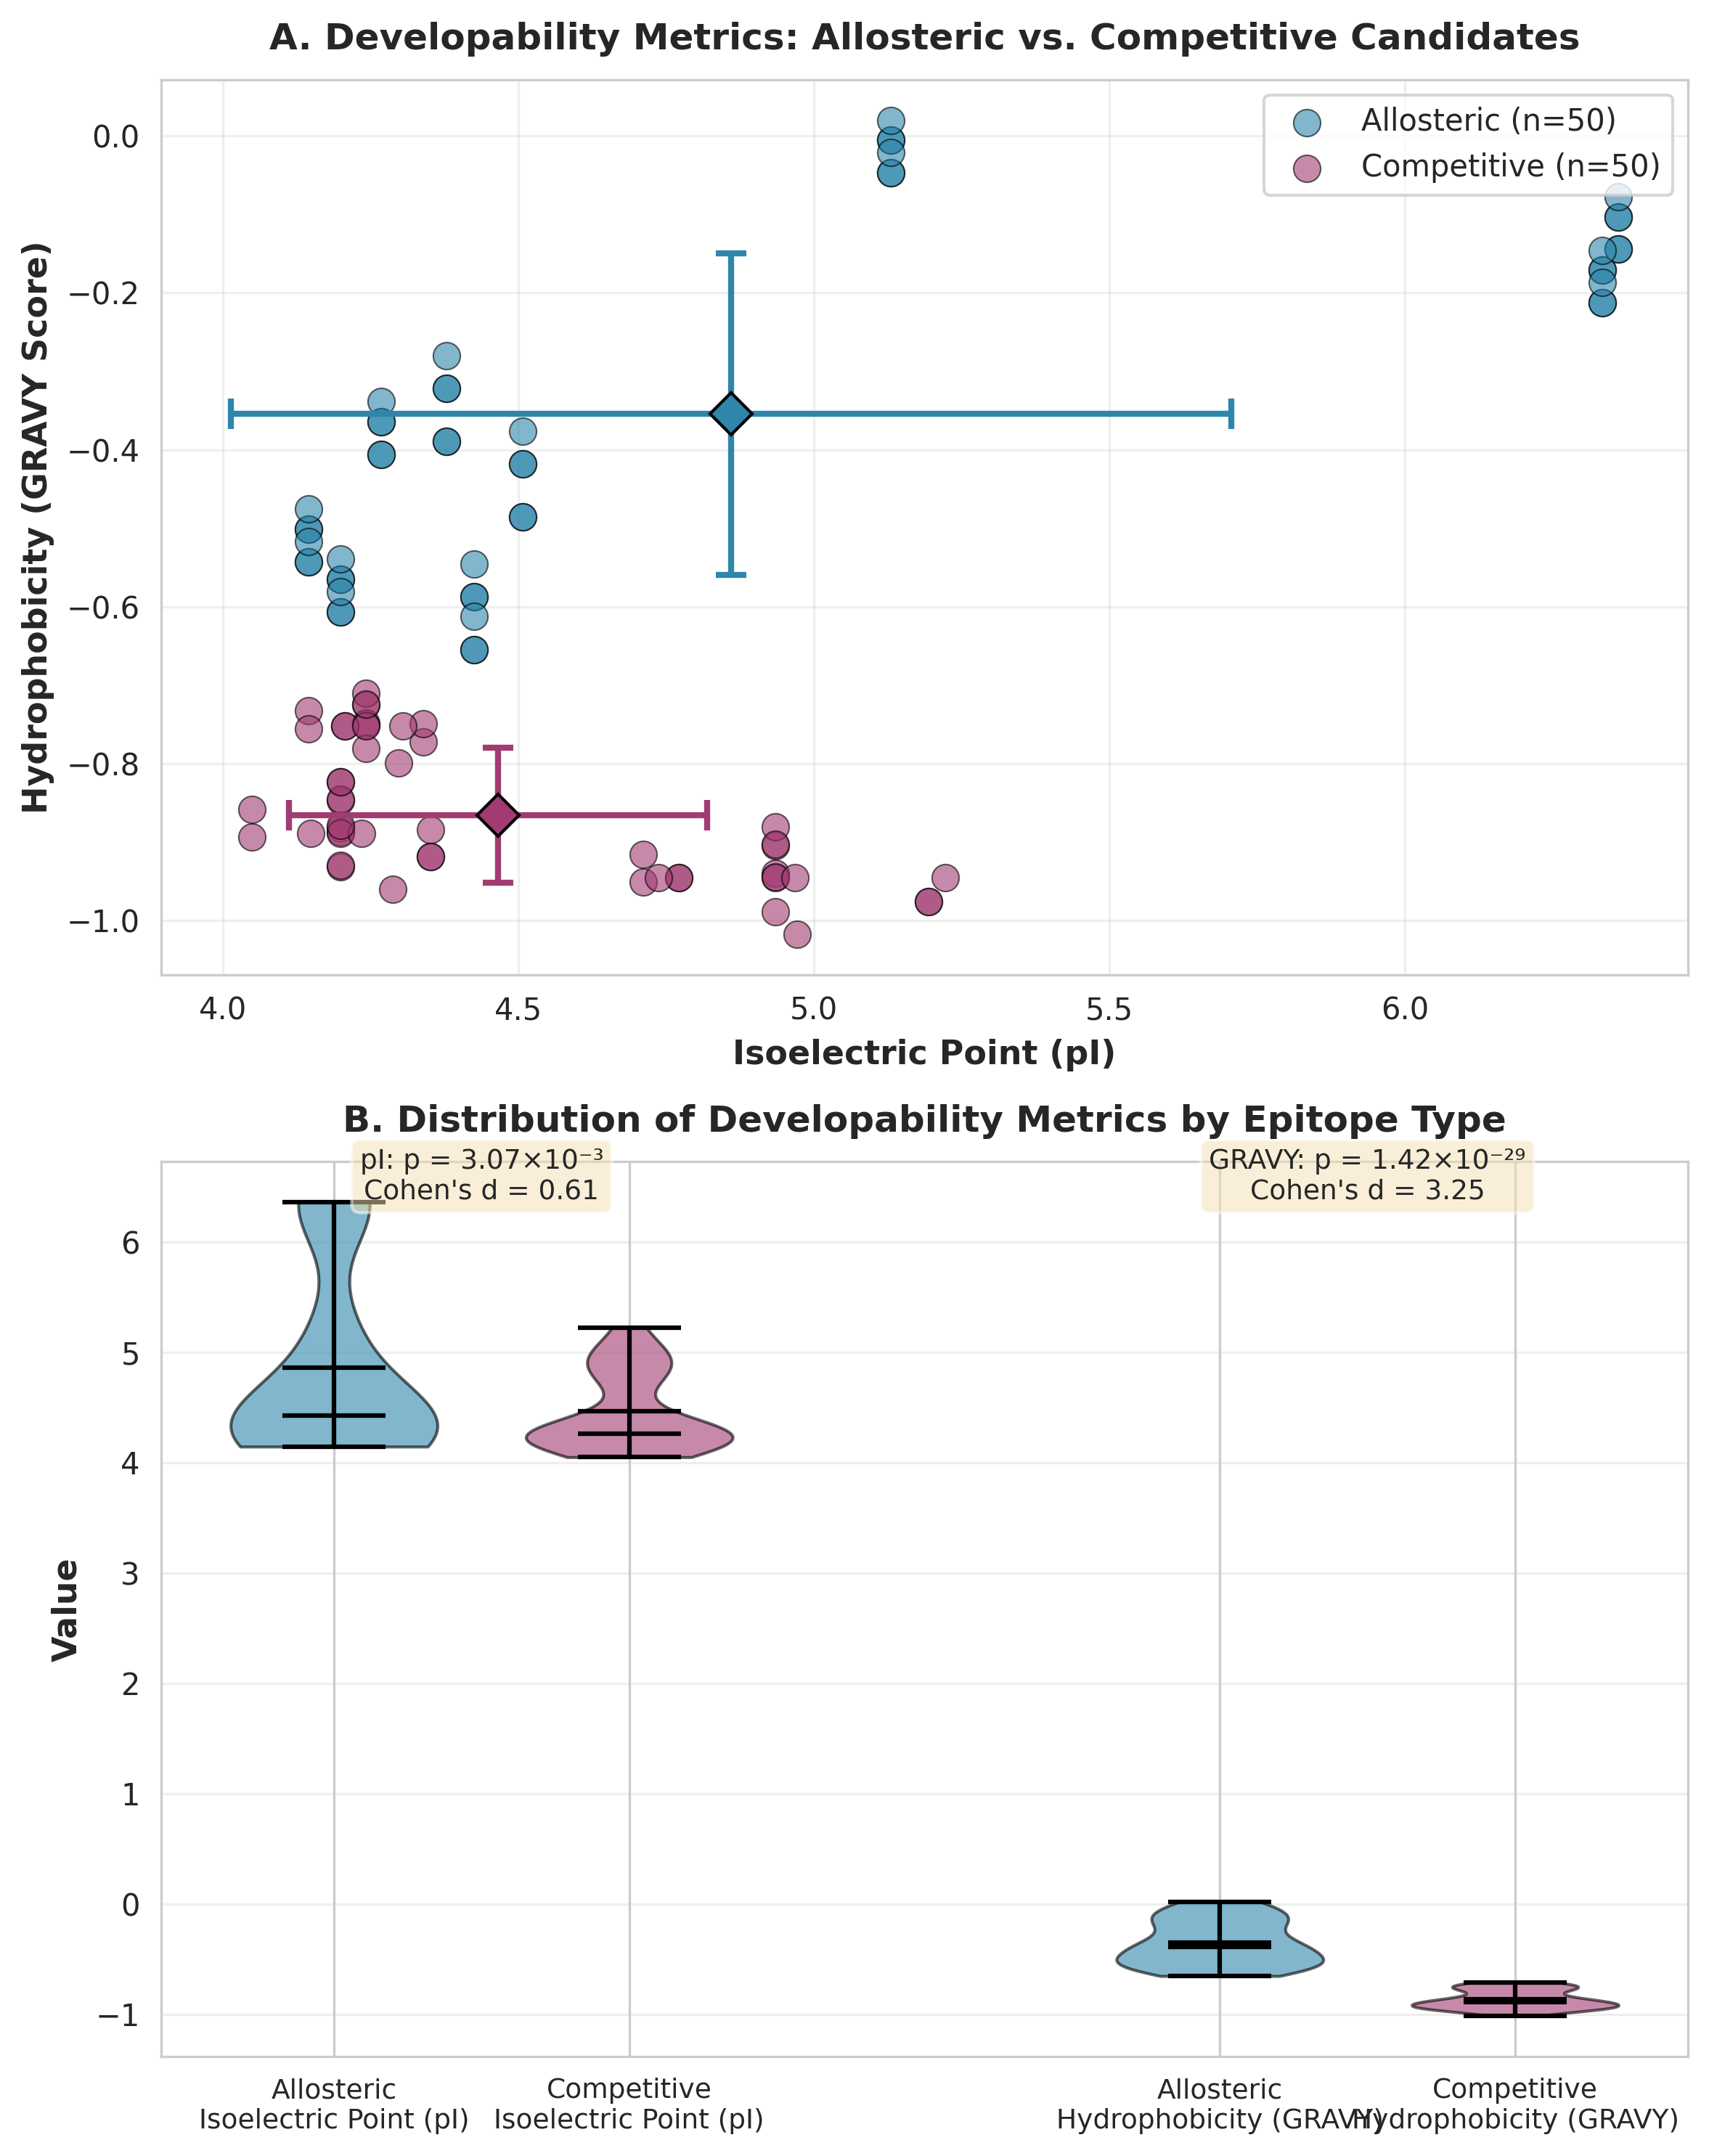

In [ ]:

# Create a comprehensive summary visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 10

# Create a single column figure with 2 panels stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Panel A: Comparison of physicochemical properties (pI and GRAVY)
# Create a scatter plot showing the two key developability metrics
allosteric_data = final_100[final_100['Target_Epitope'] == 'Allosteric']
competitive_data = final_100[final_100['Target_Epitope'] == 'Competitive']

ax1.scatter(allosteric_data['Isoelectric_Point'], allosteric_data['GRAVY_Score'], 
           s=80, alpha=0.6, color='#2E86AB', label='Allosteric (n=50)', edgecolors='black', linewidth=0.5)
ax1.scatter(competitive_data['Isoelectric_Point'], competitive_data['GRAVY_Score'], 
           s=80, alpha=0.6, color='#A23B72', label='Competitive (n=50)', edgecolors='black', linewidth=0.5)

ax1.set_xlabel('Isoelectric Point (pI)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Hydrophobicity (GRAVY Score)', fontsize=11, fontweight='bold')
ax1.set_title('A. Developability Metrics: Allosteric vs. Competitive Candidates', 
             fontsize=12, fontweight='bold', pad=10)
ax1.legend(loc='best', frameon=True, fontsize=10)
ax1.grid(True, alpha=0.3)

# Add mean markers with error bars
ax1.errorbar(allosteric_metrics['Isoelectric_Point'].mean(), 
            allosteric_metrics['GRAVY_Score'].mean(),
            xerr=allosteric_metrics['Isoelectric_Point'].std(),
            yerr=allosteric_metrics['GRAVY_Score'].std(),
            fmt='D', markersize=10, color='#2E86AB', markeredgecolor='black', 
            linewidth=2, capsize=5, capthick=2, label='Allosteric Mean ± SD')
ax1.errorbar(competitive_metrics['Isoelectric_Point'].mean(), 
            competitive_metrics['GRAVY_Score'].mean(),
            xerr=competitive_metrics['Isoelectric_Point'].std(),
            yerr=competitive_metrics['GRAVY_Score'].std(),
            fmt='D', markersize=10, color='#A23B72', markeredgecolor='black', 
            linewidth=2, capsize=5, capthick=2, label='Competitive Mean ± SD')

# Panel B: Distribution comparison as violin plots
properties = ['Isoelectric_Point', 'GRAVY_Score']
property_labels = ['Isoelectric Point (pI)', 'Hydrophobicity (GRAVY)']
positions = [0, 1, 3, 4]  # Spacing for the two groups

data_for_violin = []
labels_for_violin = []
colors_for_violin = []

# Prepare data for violin plot
for i, prop in enumerate(properties):
    data_for_violin.append(allosteric_data[prop].values)
    labels_for_violin.append(f'Allosteric\n{property_labels[i]}')
    colors_for_violin.append('#2E86AB')
    
    data_for_violin.append(competitive_data[prop].values)
    labels_for_violin.append(f'Competitive\n{property_labels[i]}')
    colors_for_violin.append('#A23B72')

# Create violin plots
parts = ax2.violinplot(data_for_violin, positions=positions, widths=0.7, 
                       showmeans=True, showmedians=True)

# Color the violin plots
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors_for_violin[i])
    pc.set_alpha(0.6)
    pc.set_edgecolor('black')
    pc.set_linewidth(1)

# Style the violin plot elements
for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians', 'cmeans'):
    if partname in parts:
        vp = parts[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(1.5)

ax2.set_xticks(positions)
ax2.set_xticklabels(labels_for_violin, fontsize=9)
ax2.set_ylabel('Value', fontsize=11, fontweight='bold')
ax2.set_title('B. Distribution of Developability Metrics by Epitope Type', 
             fontsize=12, fontweight='bold', pad=10)
ax2.grid(True, alpha=0.3, axis='y')

# Add statistical annotations
ax2.text(0.5, ax2.get_ylim()[1] * 0.95, 
        f'pI: p = 3.07×10⁻³\nCohen\'s d = 0.61', 
        ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax2.text(3.5, ax2.get_ylim()[1] * 0.95, 
        f'GRAVY: p = 1.42×10⁻²⁹\nCohen\'s d = 3.25', 
        ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('final_portfolio_summary.png', dpi=300, bbox_inches='tight')
print("Summary figure saved as 'final_portfolio_summary.png'")
plt.show()


In [ ]:

# Create a final summary of key results
print("=" * 80)
print("FINAL PORTFOLIO SUMMARY")
print("=" * 80)

print("\n### CANDIDATE COMPOSITION ###")
print(f"Total candidates: {len(final_100_output)}")
print(f"  - Allosteric candidates: 50 (all from Hybrid_3.0 strategy)")
print(f"  - Competitive candidates: 50 (all from Diversified_CDR strategy, 17-residue H3 motifs)")

print("\n### SCORING SUMMARY ###")
print("\nAllosteric candidates:")
print(f"  Binding score range: {allosteric_top50['Refined_MJ_Score'].min():.2f} to {allosteric_top50['Refined_MJ_Score'].max():.2f}")
print(f"  Top motif: LYDFGISFM (9-mer, appears in top designs)")

print("\nCompetitive candidates:")
print(f"  Normalized score range: {competitive_top50['Normalized_Score'].min():.2f} to {competitive_top50['Normalized_Score'].max():.2f}")
print(f"  All top 50 have 17-residue H3 CDR motifs")
print(f"  Length-correction applied: Residual Score method with z-score normalization")

print("\n### PHYSICOCHEMICAL PROPERTIES ###")
print("\nAllosteric candidates:")
print(f"  Isoelectric Point: {allosteric_metrics['Isoelectric_Point'].mean():.2f} ± {allosteric_metrics['Isoelectric_Point'].std():.2f}")
print(f"  GRAVY Score: {allosteric_metrics['GRAVY_Score'].mean():.3f} ± {allosteric_metrics['GRAVY_Score'].std():.3f}")
print(f"  Interpretation: More hydrophilic, less negative GRAVY")

print("\nCompetitive candidates:")
print(f"  Isoelectric Point: {competitive_metrics['Isoelectric_Point'].mean():.2f} ± {competitive_metrics['Isoelectric_Point'].std():.2f}")
print(f"  GRAVY Score: {competitive_metrics['GRAVY_Score'].mean():.3f} ± {competitive_metrics['GRAVY_Score'].std():.3f}")
print(f"  Interpretation: More hydrophobic, highly negative GRAVY")

print("\n### STATISTICAL COMPARISON ###")
print(f"\nIsoelectric Point difference:")
print(f"  t-statistic: {t_stat_pi:.3f}")
print(f"  p-value: {p_val_pi:.3e} (significant at α=0.05)")
print(f"  Cohen's d: {d_pi:.3f} (medium effect size)")
print(f"  Conclusion: Allosteric candidates have significantly higher pI than competitive")

print(f"\nGRAVY Score difference:")
print(f"  t-statistic: {t_stat_gravy:.3f}")
print(f"  p-value: {p_val_gravy:.3e} (highly significant)")
print(f"  Cohen's d: {d_gravy:.3f} (very large effect size)")
print(f"  Conclusion: Allosteric candidates are significantly less hydrophobic than competitive")

print("\n### DIVERSITY METRICS ###")
print(f"\nUnique motifs in allosteric top 50: {allosteric_top50['Motif'].nunique()}")
print(f"Unique motifs in competitive top 50: {competitive_top50['Motif'].nunique()}")
print(f"Scaffold distribution in competitive candidates:")
print(competitive_top50_full['scaffold'].value_counts().to_string())

print("\n### OUTPUT FILE ###")
print("Final candidate list saved as: final_100_synthesis_candidates.csv")
print("Columns: Final_Rank, Strategy_Rank, Target_Epitope, Design_Strategy,")
print("         Sequence, Motif, Binding_Score, Isoelectric_Point, GRAVY_Score")

print("\n" + "=" * 80)


FINAL PORTFOLIO SUMMARY

### CANDIDATE COMPOSITION ###
Total candidates: 100
  - Allosteric candidates: 50 (all from Hybrid_3.0 strategy)
  - Competitive candidates: 50 (all from Diversified_CDR strategy, 17-residue H3 motifs)

### SCORING SUMMARY ###

Allosteric candidates:
  Binding score range: -419.68 to -415.26
  Top motif: LYDFGISFM (9-mer, appears in top designs)

Competitive candidates:
  Normalized score range: 1.79 to 1.79
  All top 50 have 17-residue H3 CDR motifs
  Length-correction applied: Residual Score method with z-score normalization

### PHYSICOCHEMICAL PROPERTIES ###

Allosteric candidates:
  Isoelectric Point: 4.86 ± 0.85
  GRAVY Score: -0.355 ± 0.205
  Interpretation: More hydrophilic, less negative GRAVY

Competitive candidates:
  Isoelectric Point: 4.47 ± 0.35
  GRAVY Score: -0.866 ± 0.086
  Interpretation: More hydrophobic, highly negative GRAVY

### STATISTICAL COMPARISON ###

Isoelectric Point difference:
  t-statistic: 3.036
  p-value: 3.068e-03 (significant